In [34]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

Load Data

In [2]:
data_folder = '/content/drive/My Drive/InitialDataSet-AIvsHD'

Categories = ["AI", "HD"]

IMG_SIZE = 128

for category in Categories:
    path = os.path.join(data_folder, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        #plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        #plt.title(f"Category: {category}")
        #plt.show()

Process

In [3]:
data = []
labels = []

# Load images and labels
for category in Categories:
    path = os.path.join(data_folder, category)  # Path to category folder
    class_num = Categories.index(category)  # Assign labels: 0 for 'AI', 1 for 'HD'

    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)  # Read image
            resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize image
            data.append(resized_array)  # Append image data
            labels.append(class_num)  # Append label
        except Exception as e:
            print(f"Error loading image {img}: {e}")  # Handle loading errors

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Normalize pixel values (0-255 to 0-1)
data = data / 255.0

Splitting Data

In [4]:
# Split into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.4, random_state=42)

# Convert labels to categorical (one-hot encoding) if needed for the model
y_train = to_categorical(y_train, num_classes=len(Categories))
y_test = to_categorical(y_test, num_classes=len(Categories))

# Print shapes for confirmation
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (1806, 128, 128, 3)
y_train shape: (1806, 2)
x_test shape: (1204, 128, 128, 3)
y_test shape: (1204, 2)


Display Sample Training Data

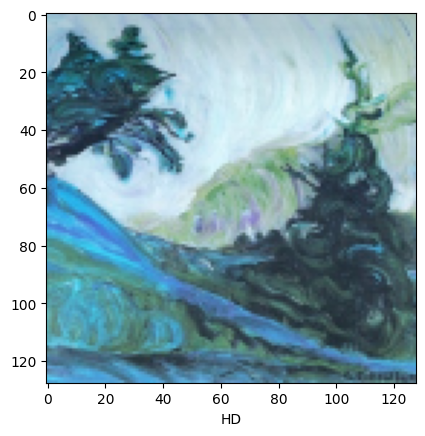

In [36]:
def plot_sample(x, y, index):
    plt.imshow(x[index])
    plt.xlabel(Categories[np.argmax(y[index])])
    plt.show()  # Display the image
    return x[index]  # Return the image data

image = plot_sample(x_train, y_train, 11)  # Now image will hold the image data


Testing if the Images are Classified Correctly

In [6]:
print("Categories:", Categories)
print("Sample Label from y_train:", y_train[0])


Categories: ['AI', 'HD']
Sample Label from y_train: [0. 1.]


Model Training

In [7]:
cnn = models.Sequential([

    #cnn
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3), name='custom_conv1'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='custom_conv2'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', name='custom_conv3'),
    layers.MaxPooling2D((2,2)),

    #dense
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

cnn.fit(x_train, y_train, epochs=5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5923 - loss: 0.6492
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7483 - loss: 0.5171
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7861 - loss: 0.4449
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8022 - loss: 0.4246
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8405 - loss: 0.3437


Evaluation

In [8]:
cnn.evaluate(x_test, y_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 347ms/step - accuracy: 0.7840 - loss: 0.4272


[0.4391191005706787, 0.7774086594581604]

Evaluation Report

In [9]:
y_pred = cnn.predict(x_test)
y_pred_Categories = [np.argmax(element) for element in y_pred]
y_test_Categories = [np.argmax(element) for element in y_test]

print("Classification Report: \n", classification_report(y_test_Categories, y_pred_Categories))


# MAE and RMSE

print("Regression Metrics: \n")

mae = mean_absolute_error(y_test_Categories, y_pred_Categories)
print(f"Mean Absolute Error (MAE): {mae}")


mse = mean_squared_error(y_test_Categories, y_pred_Categories)  # Calculate MSE
rmse = np.sqrt(mse)  # Calculate RMSE manually
print(f"Root Mean Squared Error (RMSE): {rmse}")



38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 333ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.67      0.76       617
           1       0.72      0.89      0.80       587

    accuracy                           0.78      1204
   macro avg       0.79      0.78      0.78      1204
weighted avg       0.79      0.78      0.78      1204

Regression Metrics: 

Mean Absolute Error (MAE): 0.22259136212624583
Root Mean Squared Error (RMSE): 0.47179589032360786


Layer Names

In [10]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ custom_conv1 (Conv2D)                │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_conv2 (Conv2D)                │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_conv3 (Conv2D)                │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,097,224 (19.44 MB)

 Trainable params: 1,699,074 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,398,150 (12.96 MB)

**Feature Vizualization**

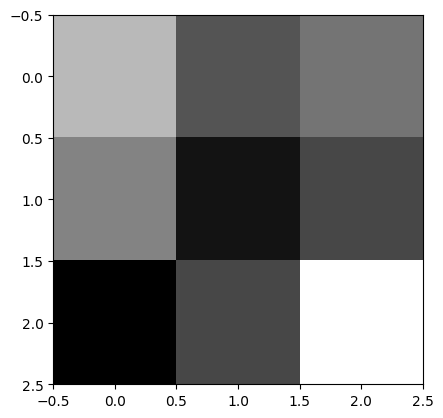

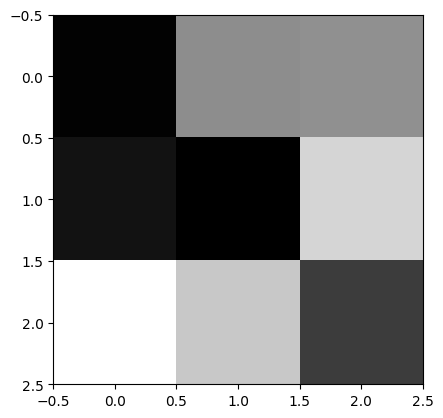

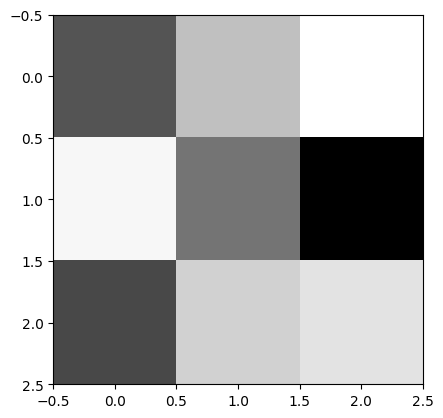

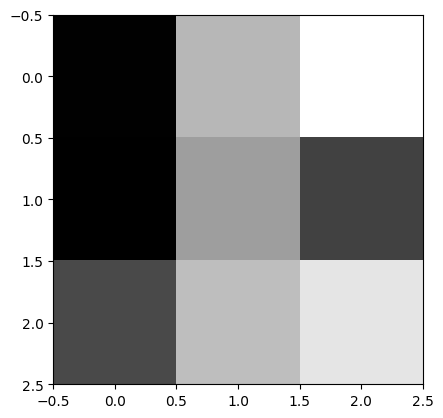

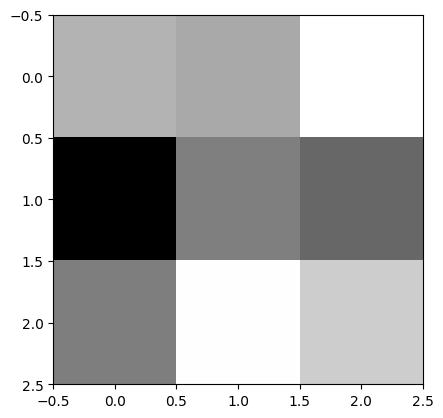

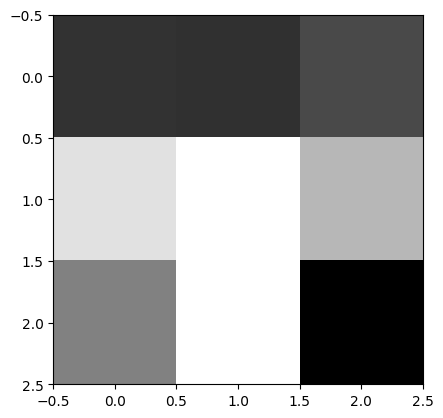

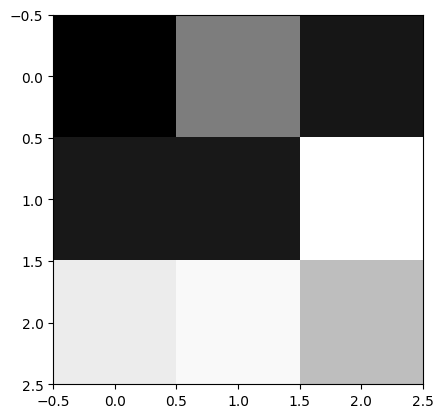

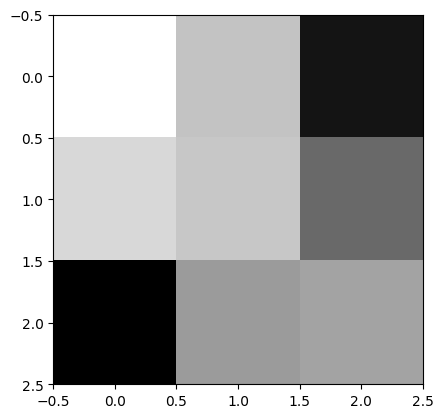

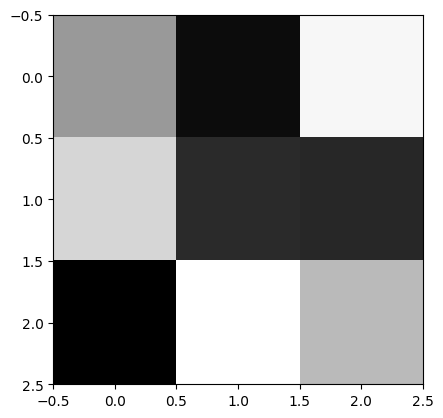

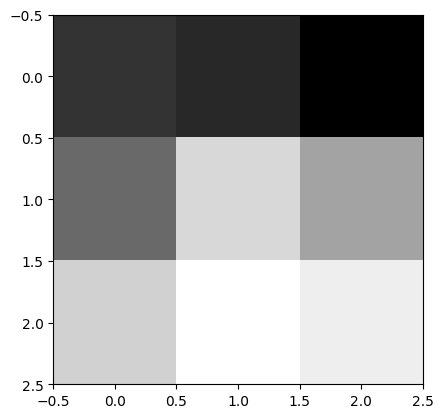

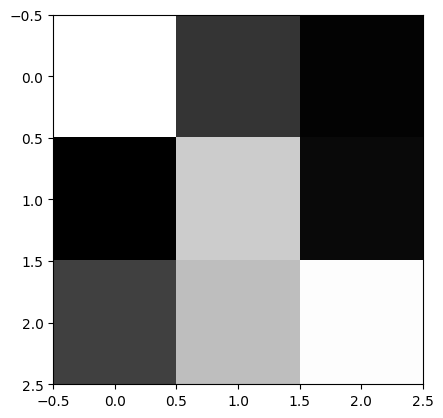

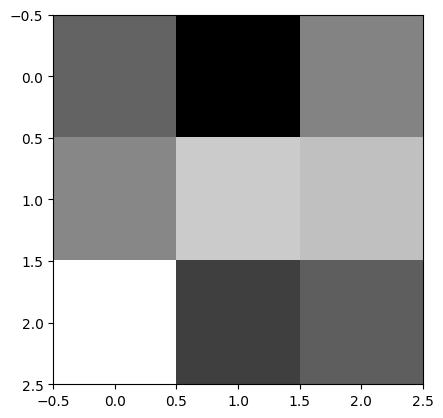

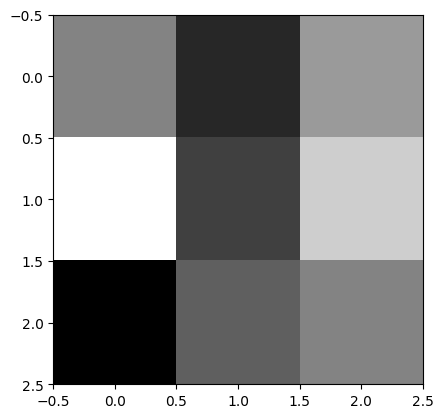

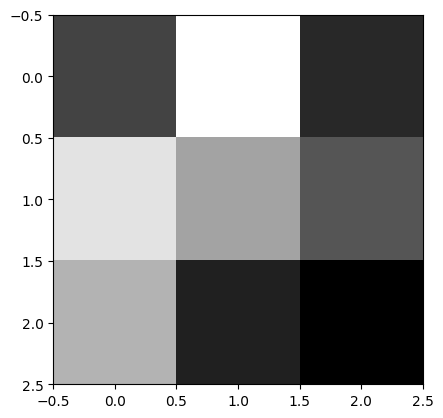

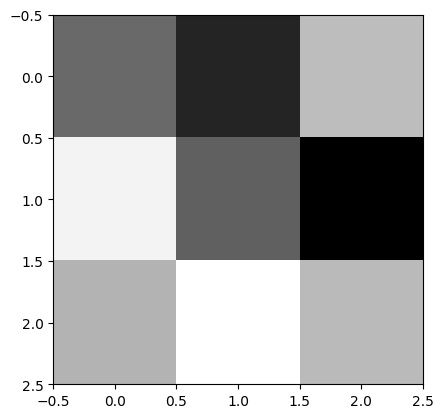

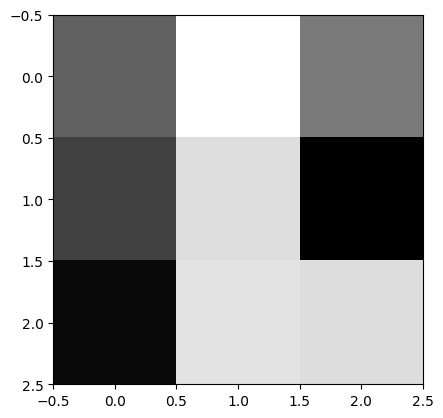

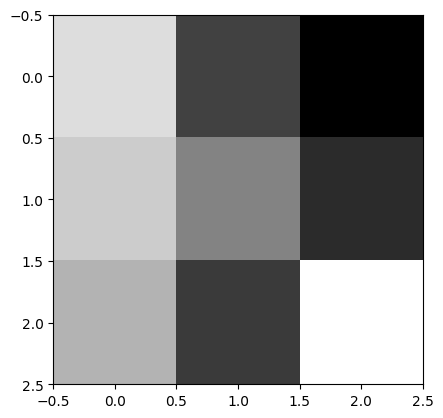

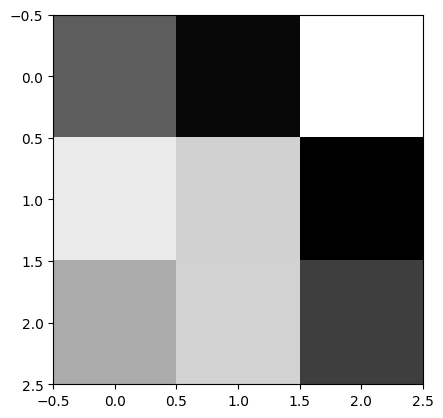

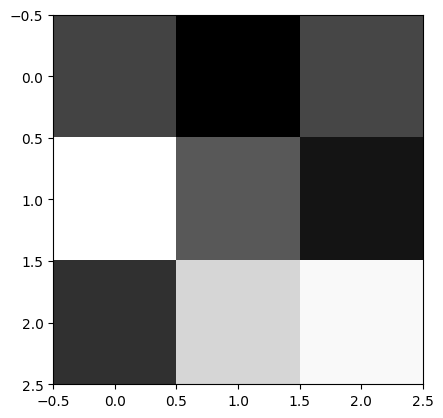

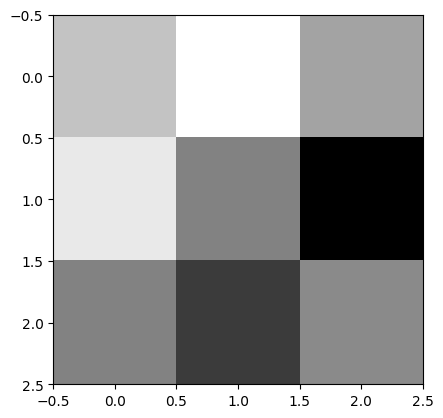

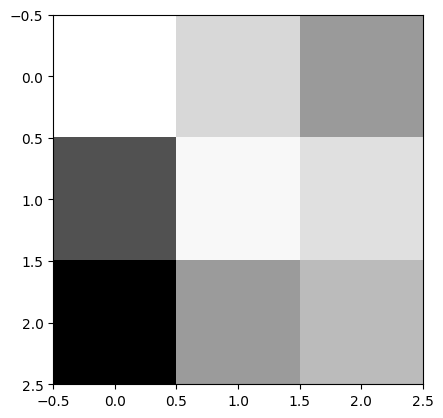

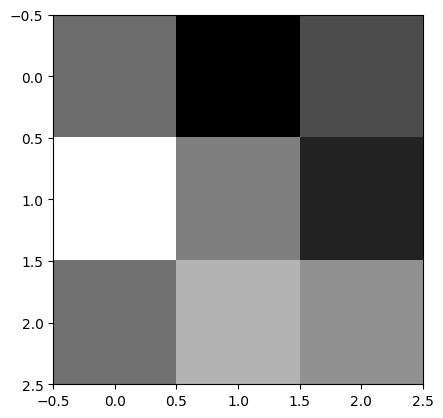

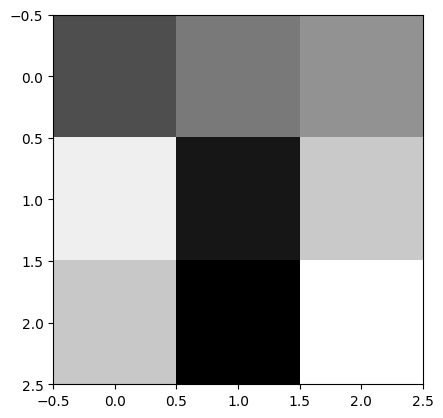

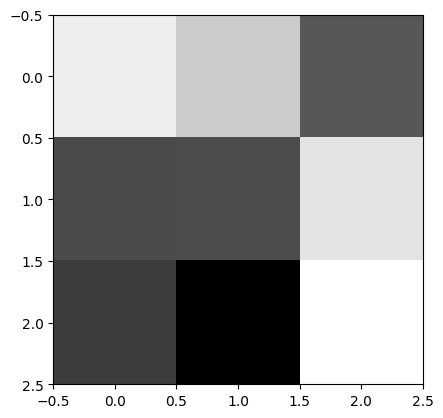

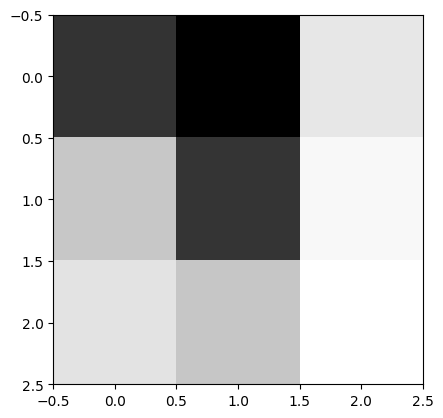

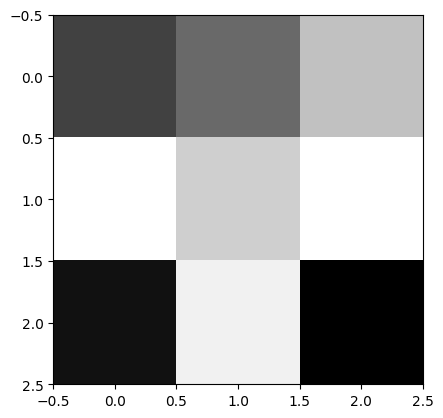

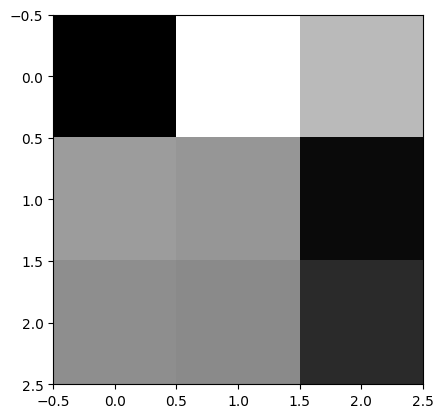

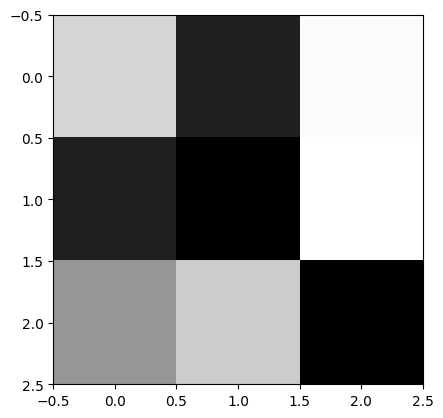

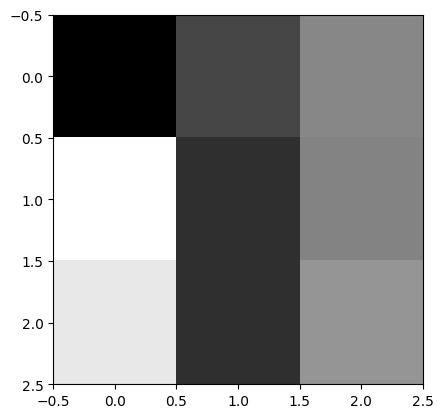

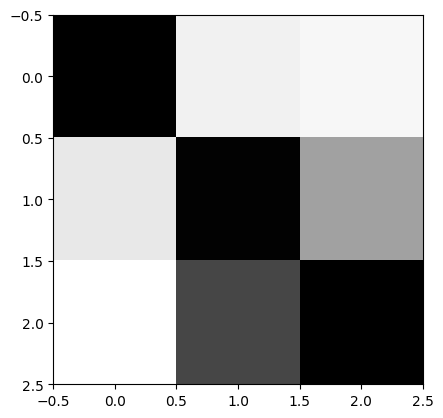

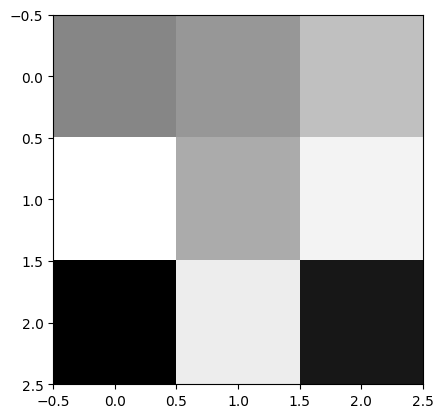

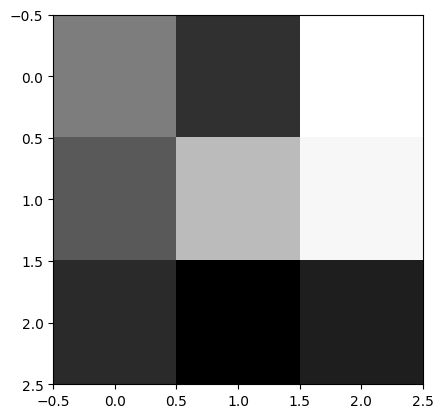

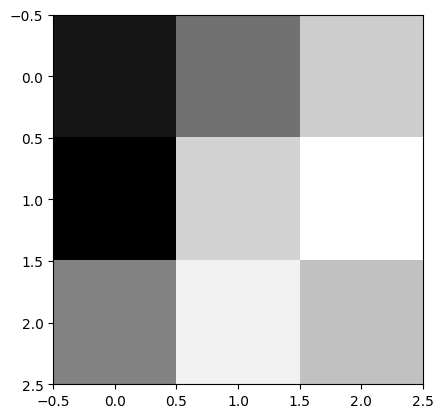

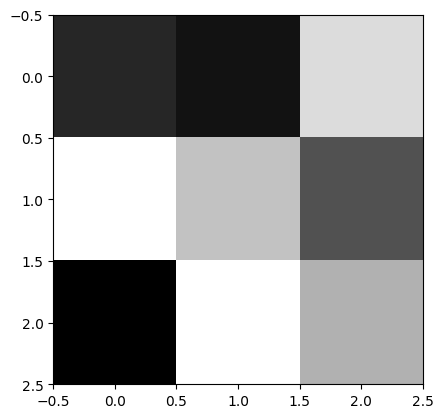

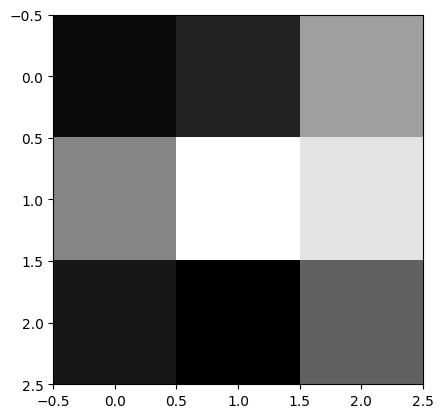

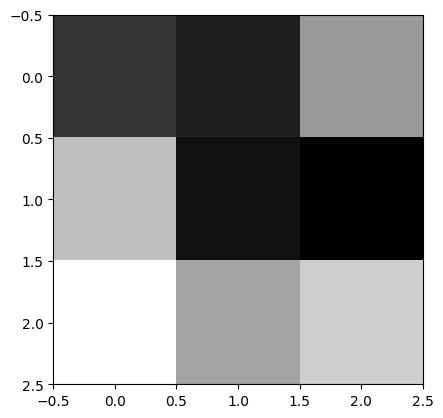

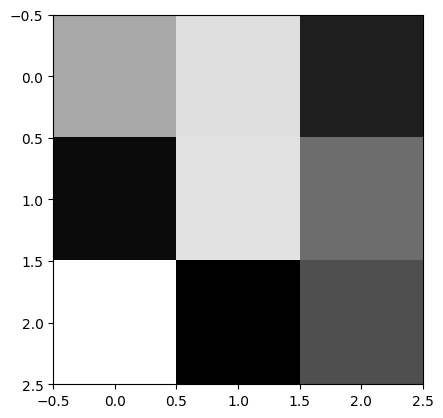

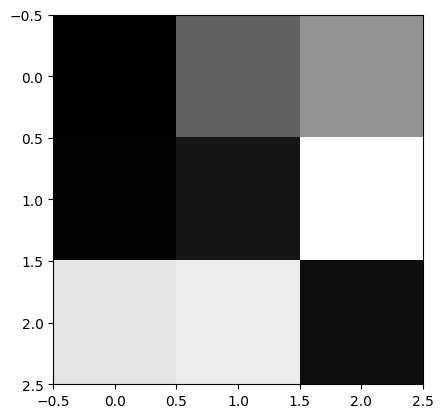

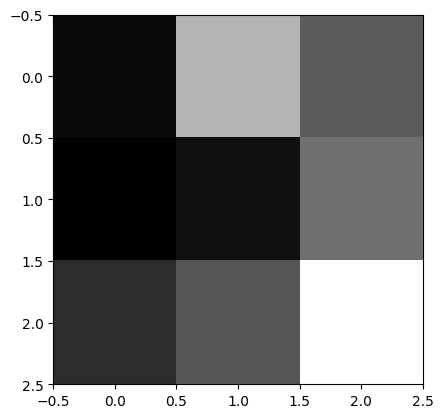

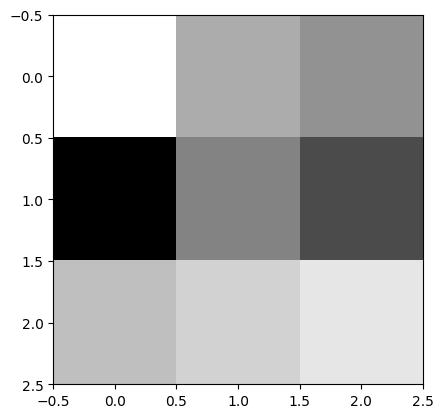

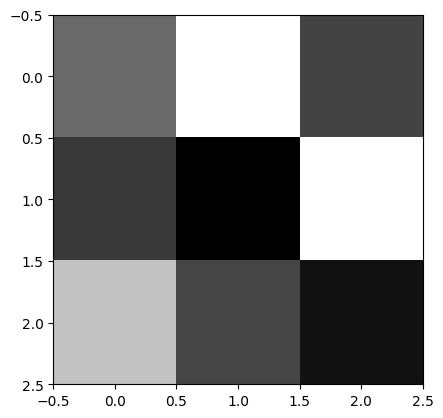

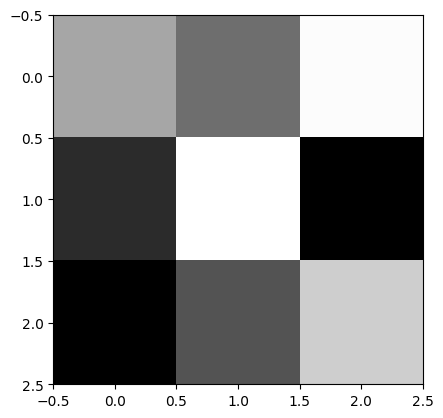

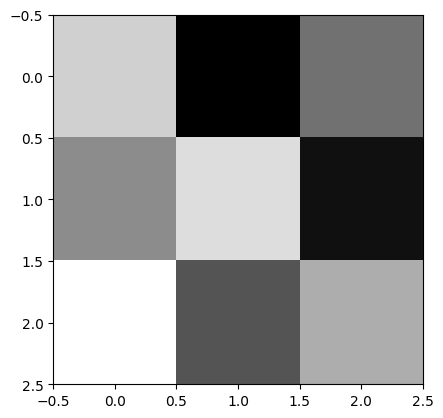

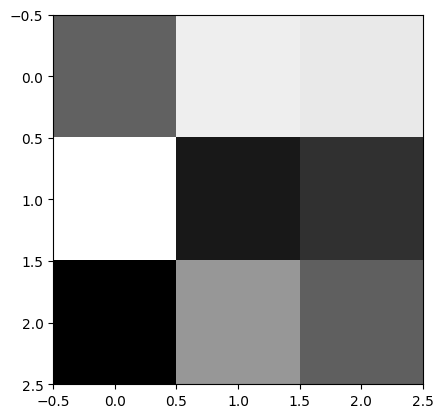

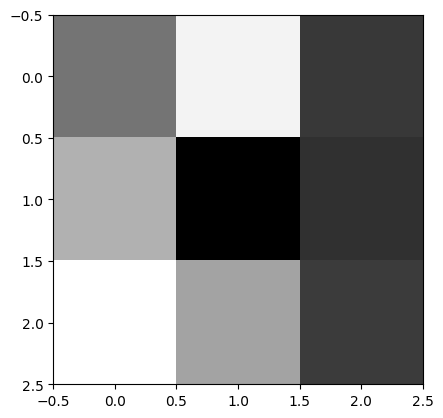

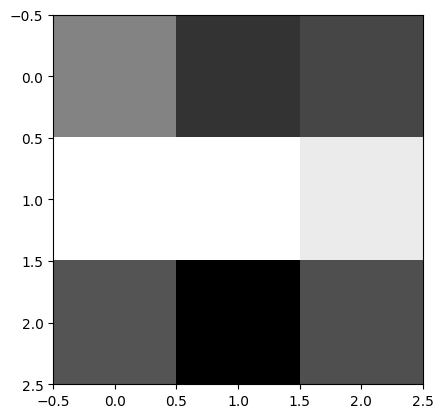

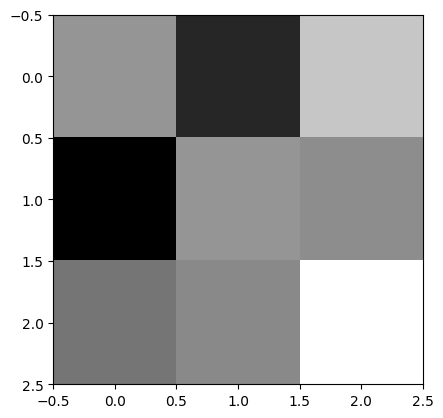

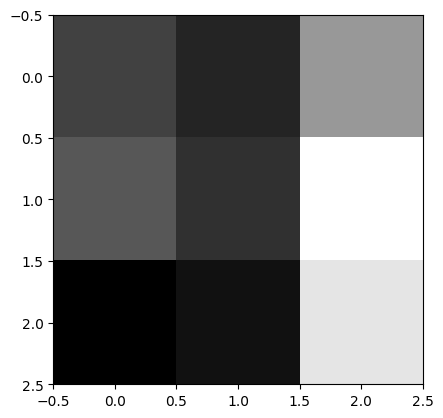

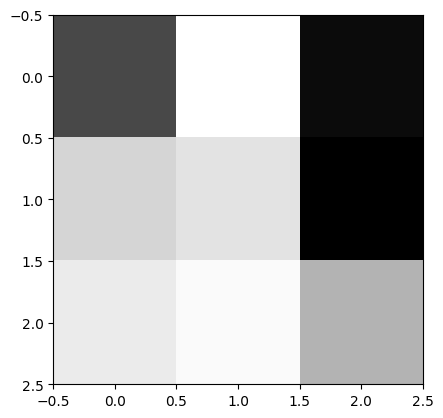

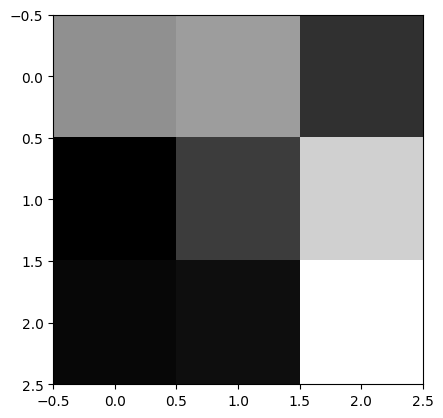

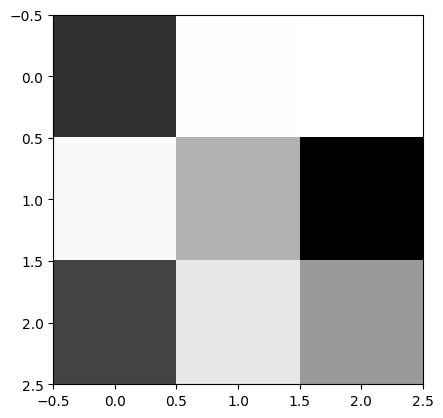

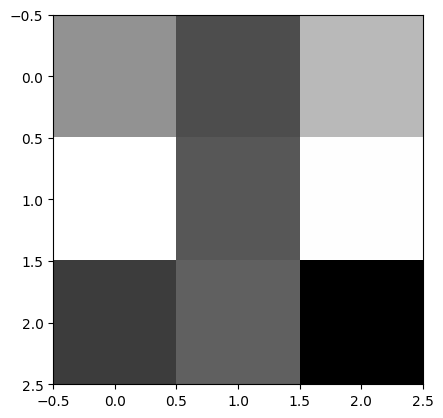

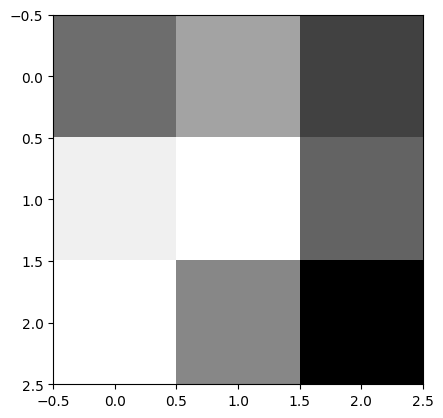

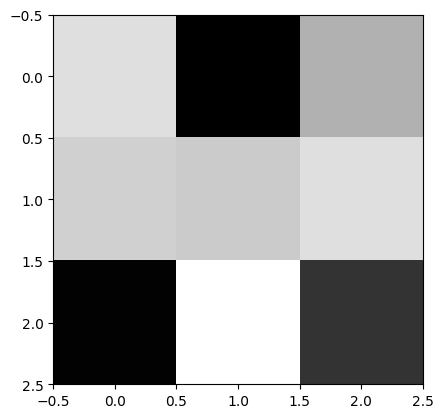

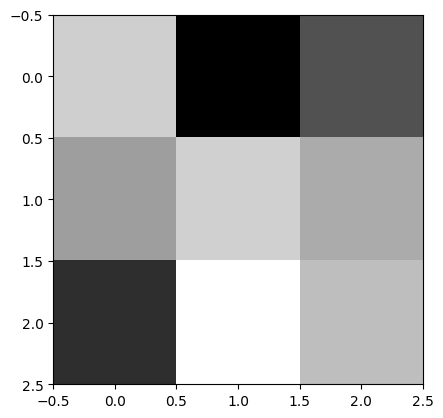

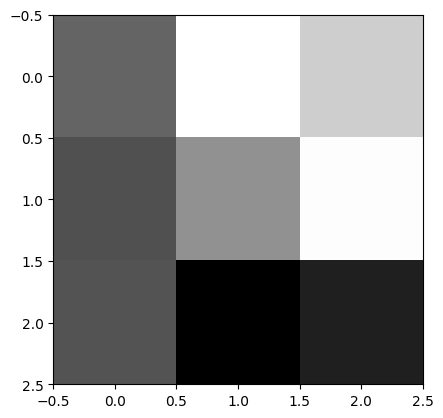

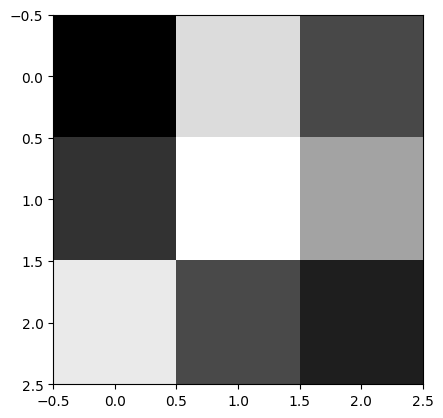

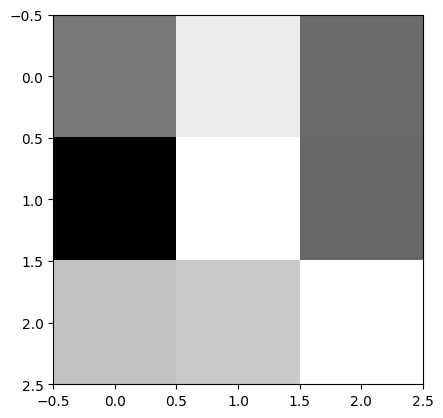

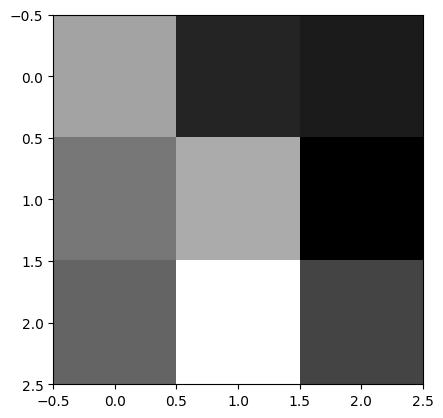

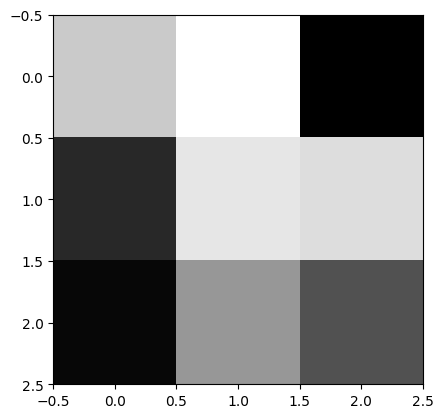

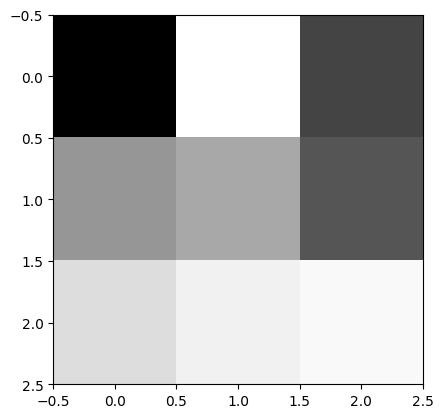

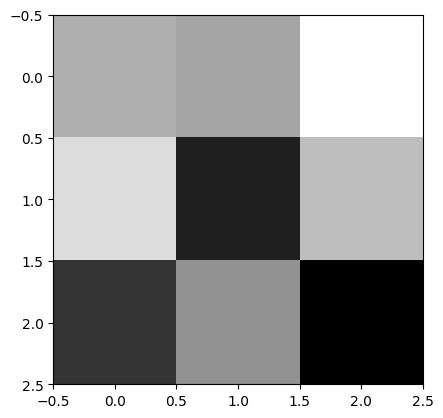

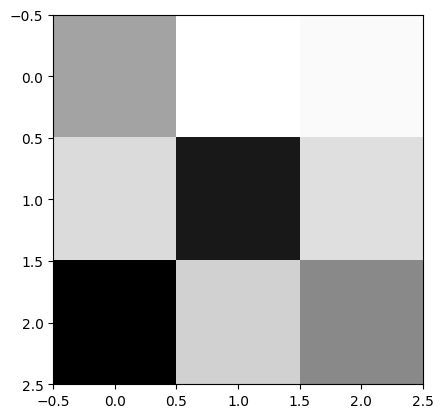

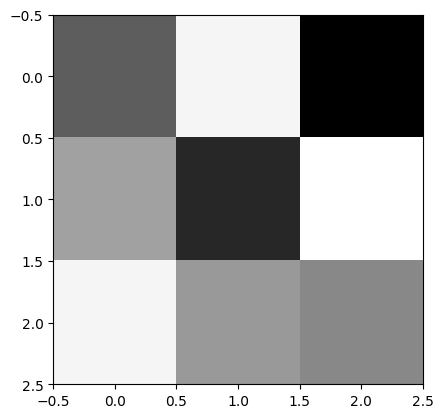

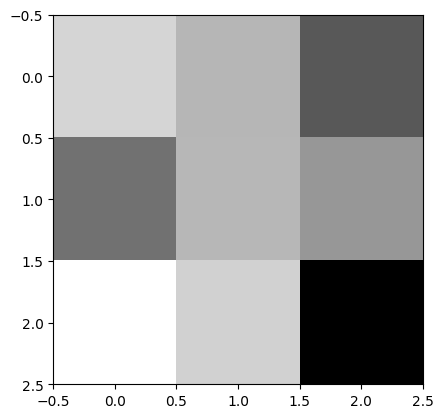

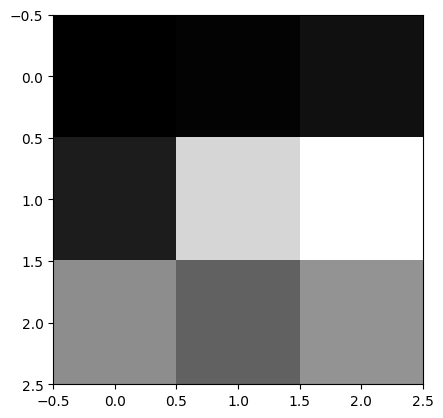

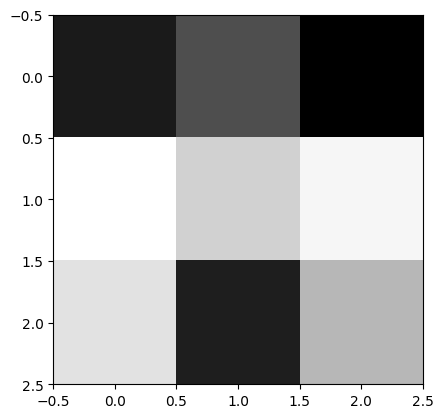

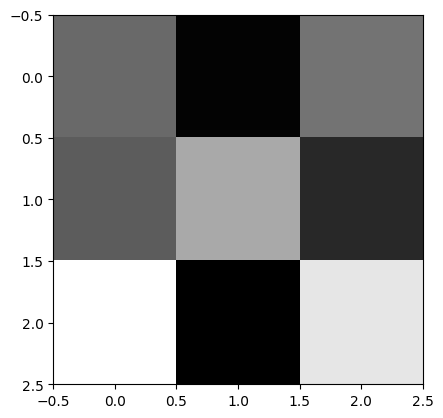

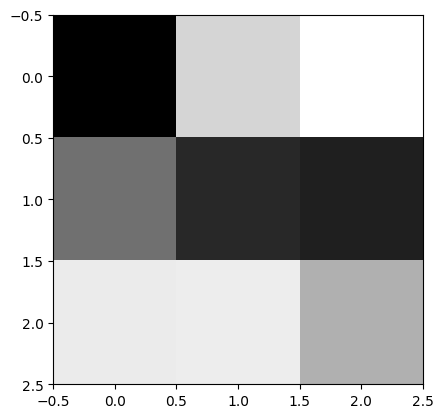

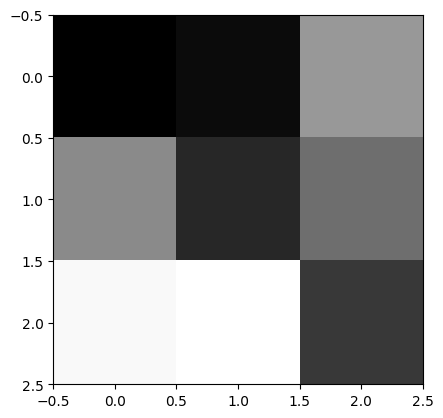

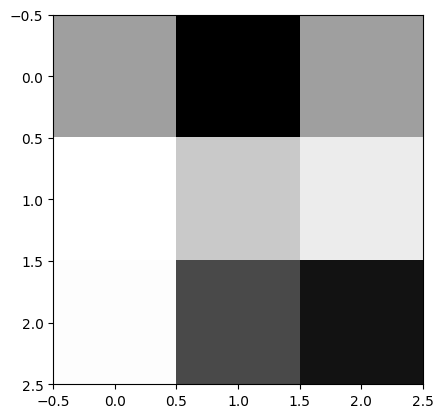

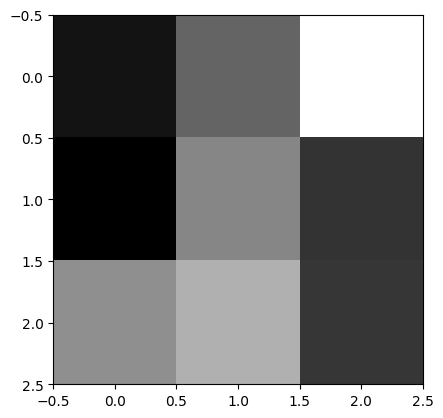

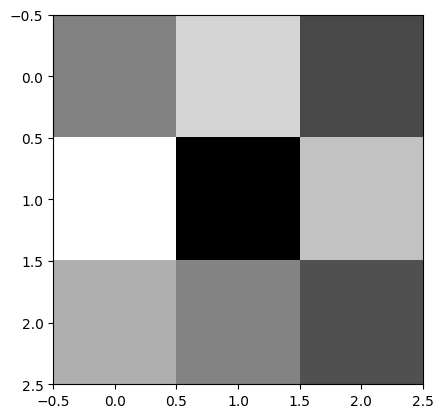

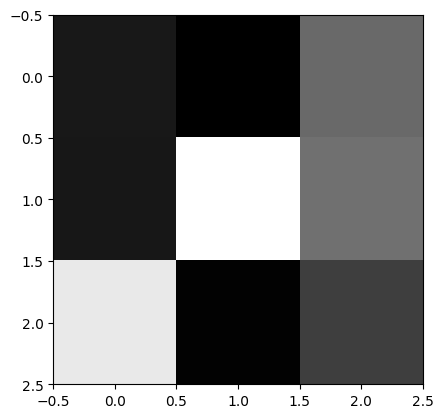

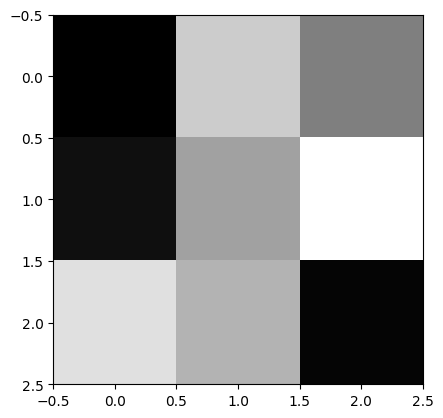

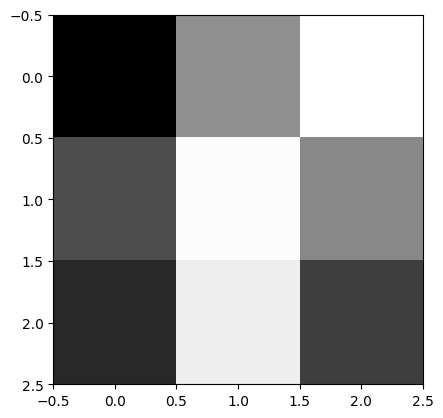

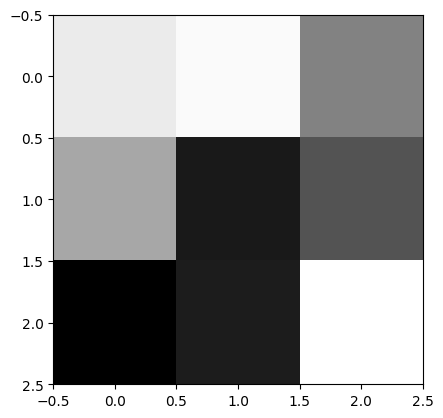

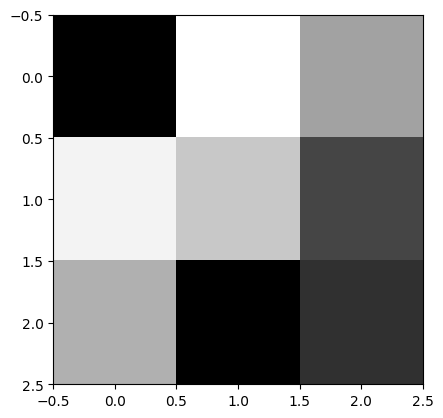

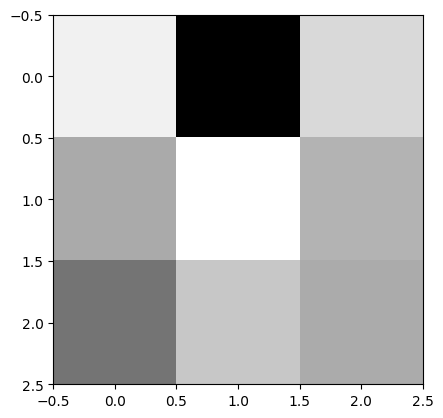

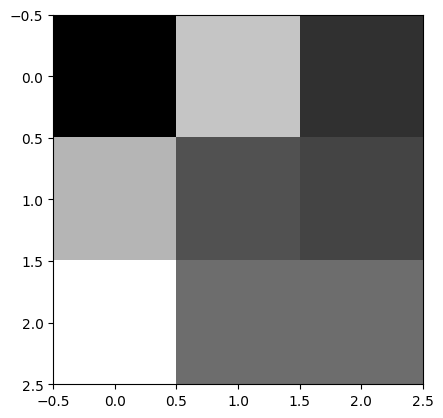

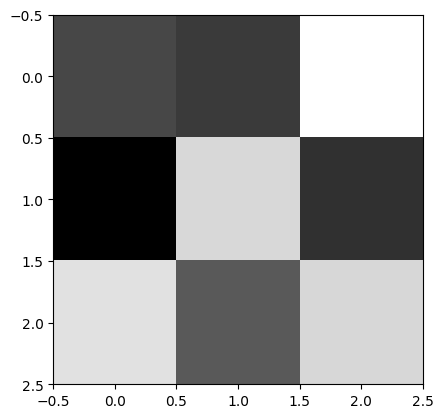

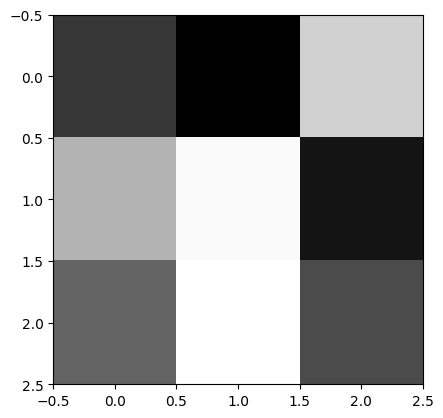

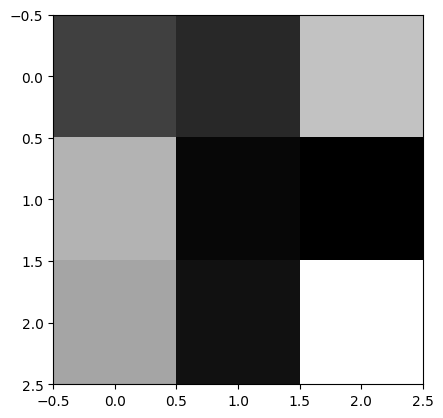

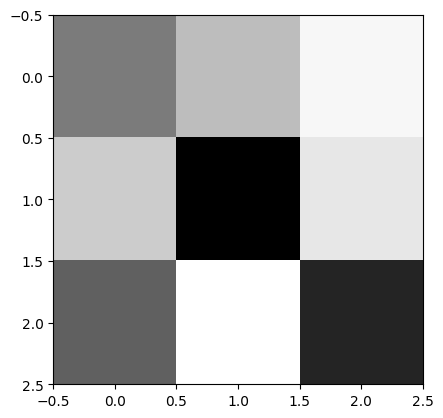

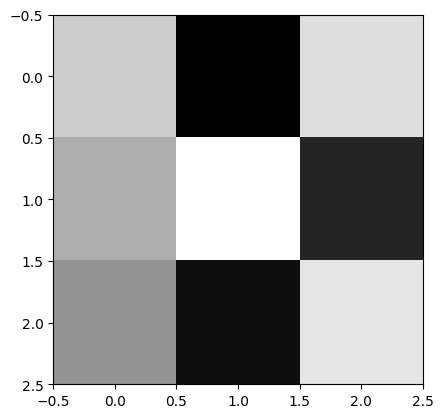

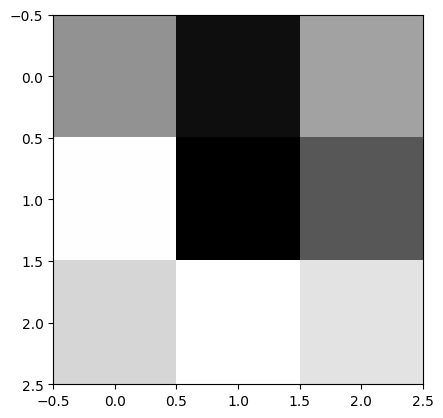

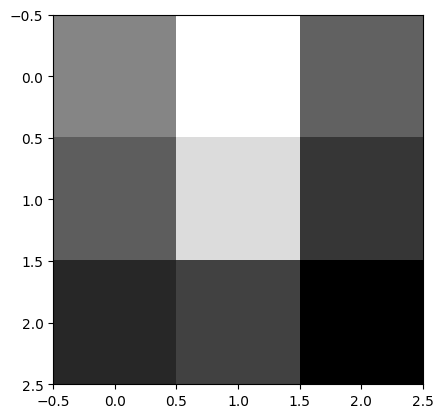

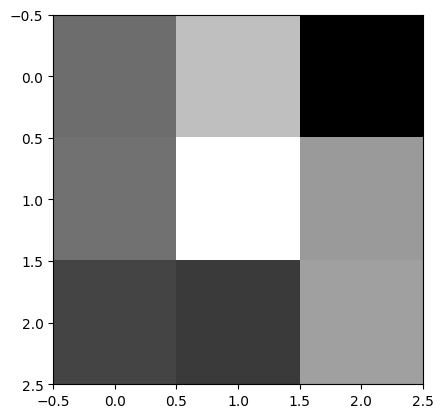

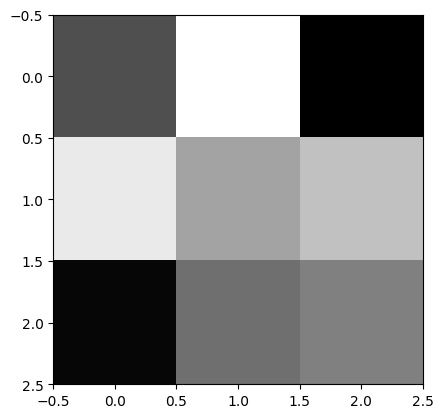

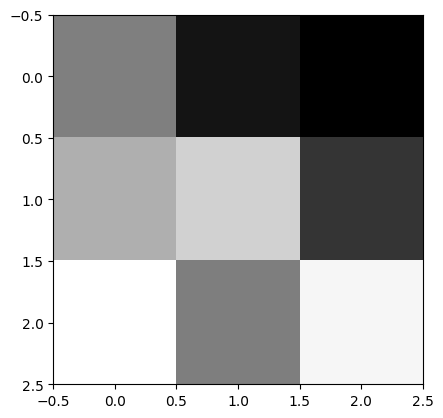

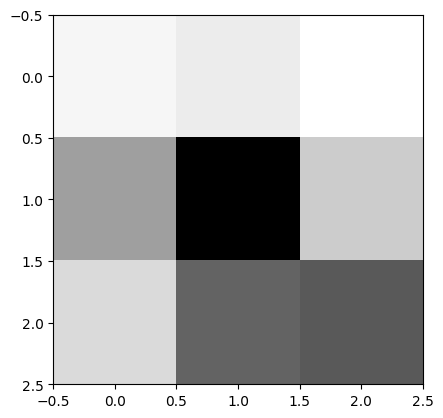

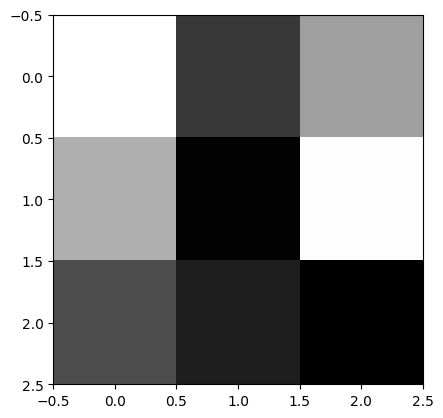

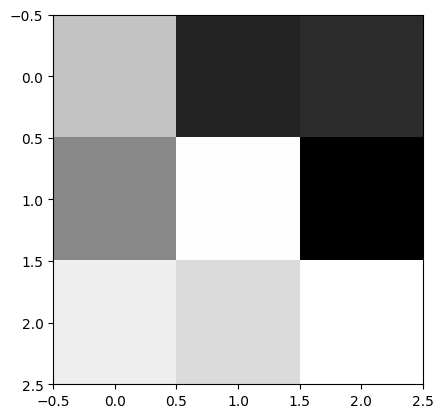

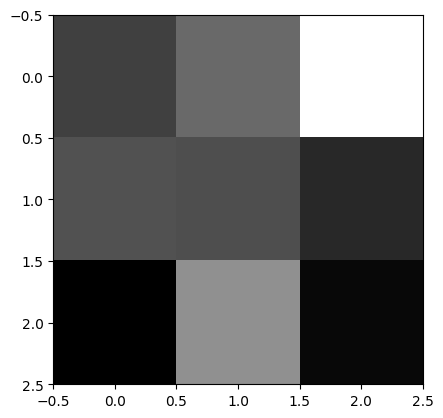

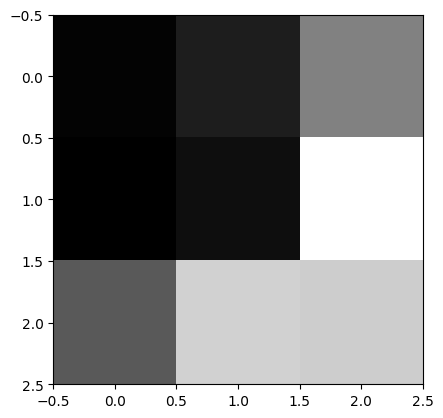

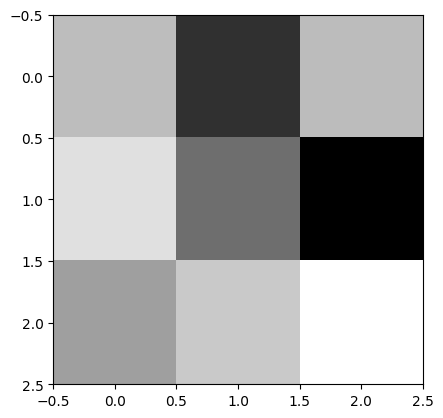

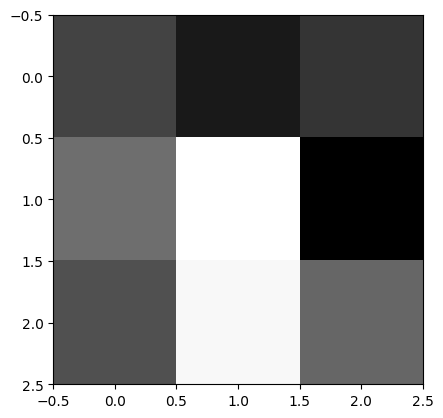

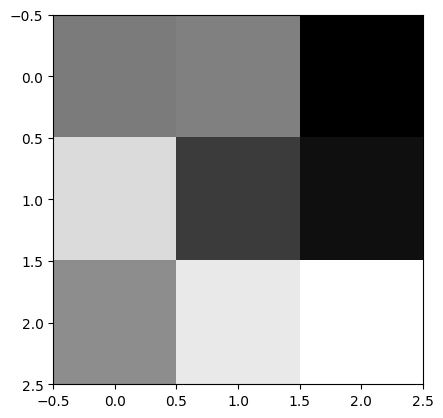

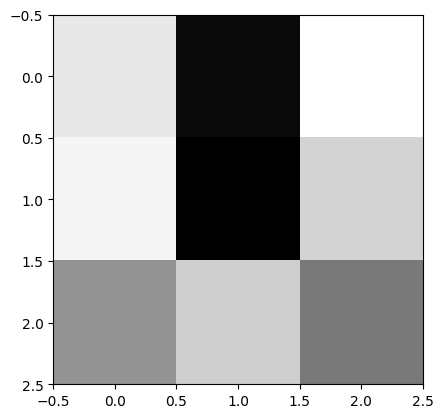

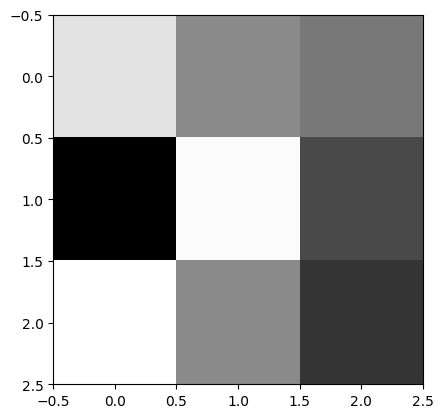

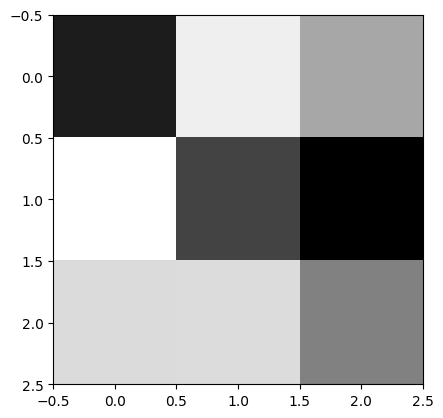

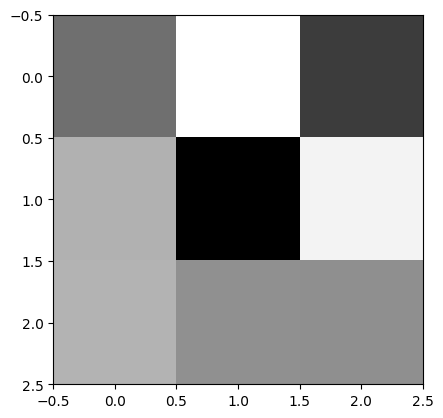

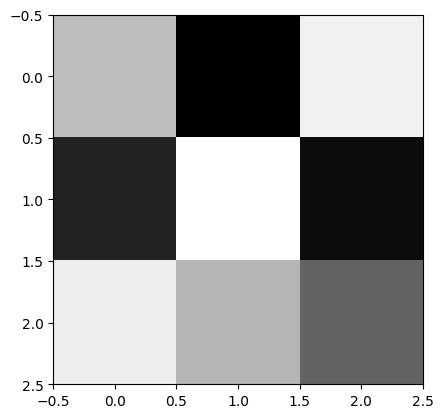

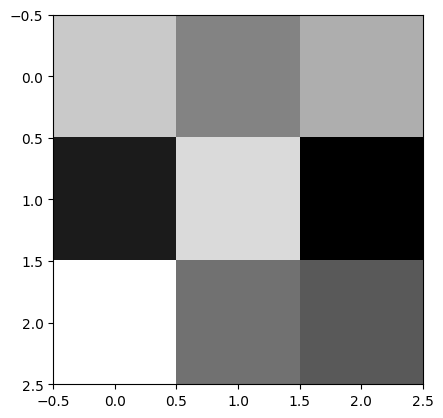

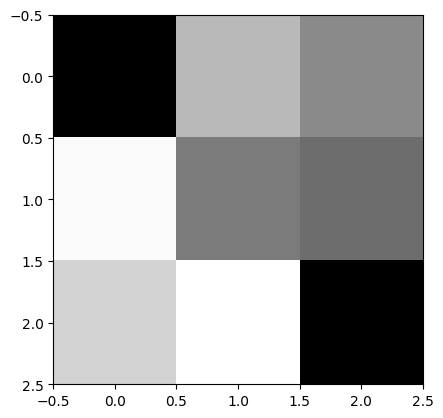

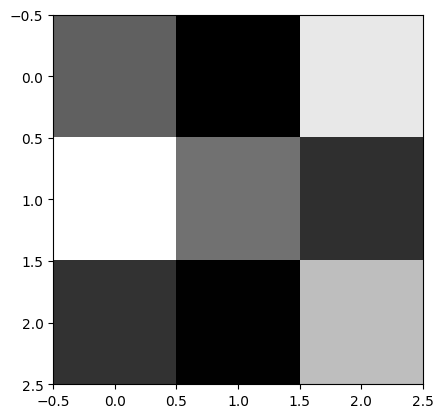

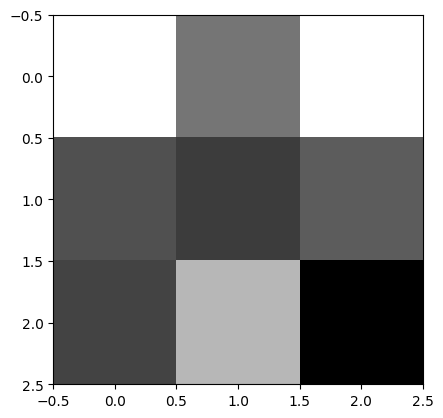

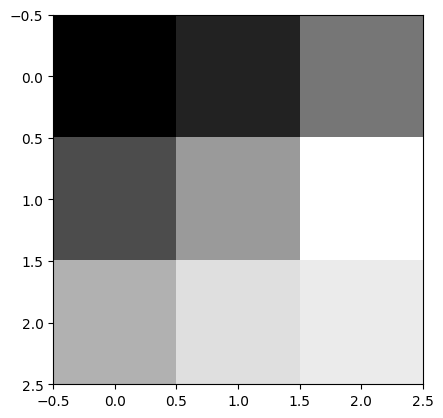

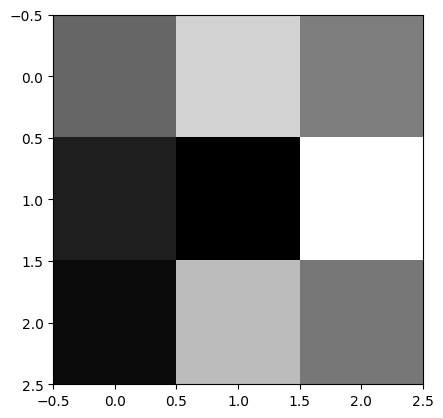

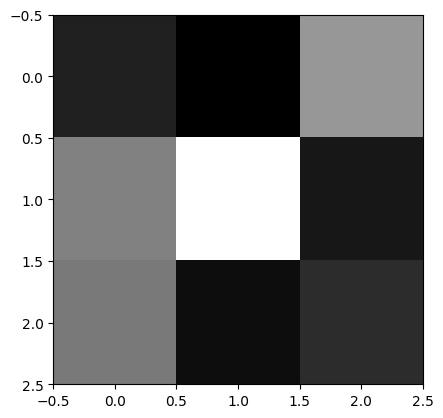

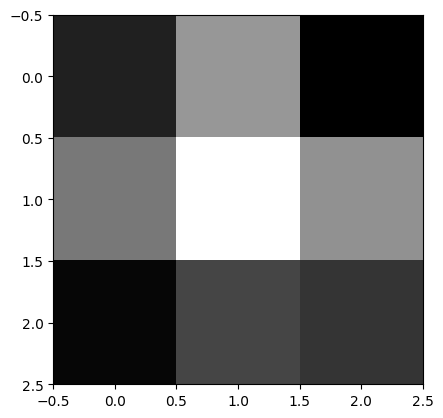

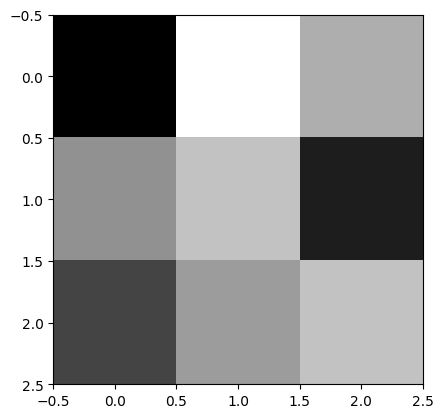

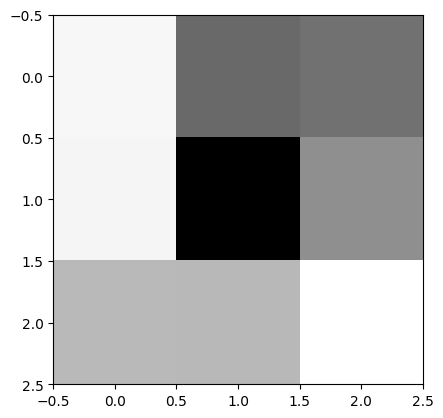

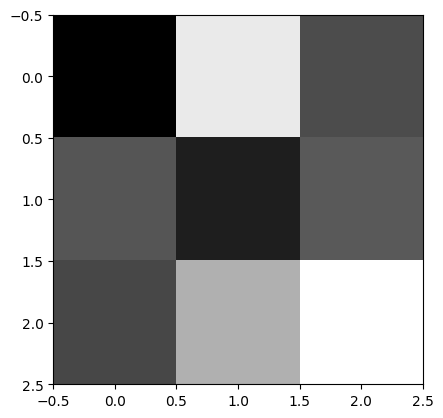

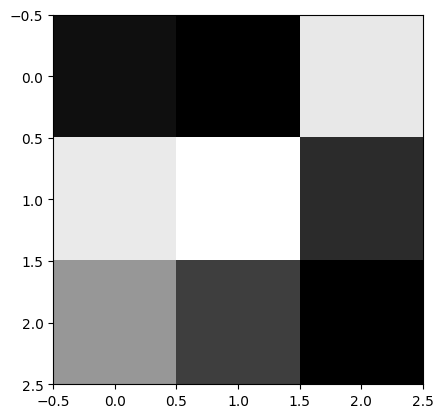

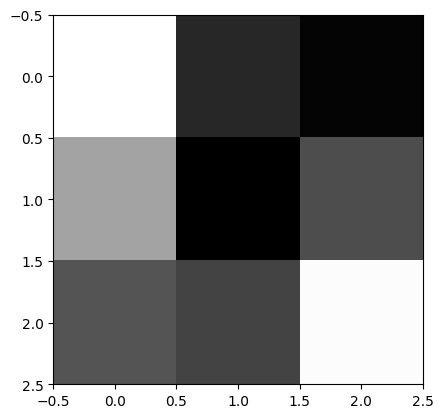

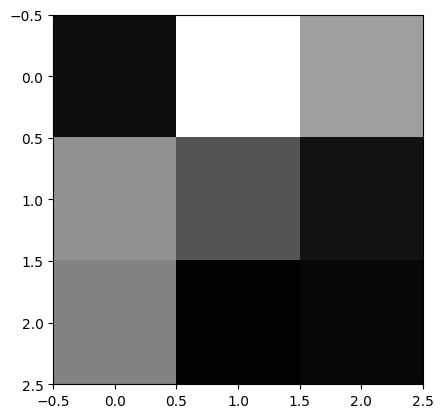

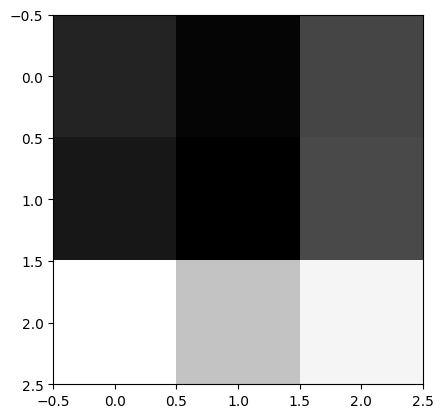

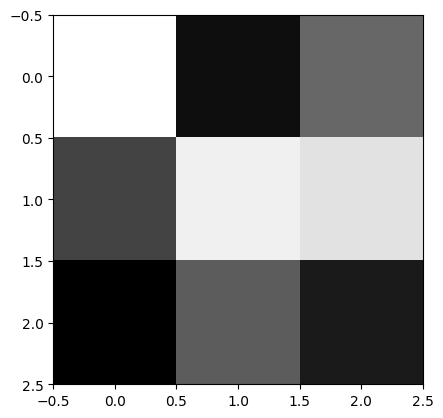

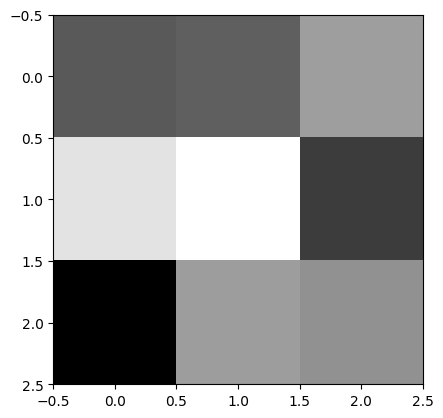

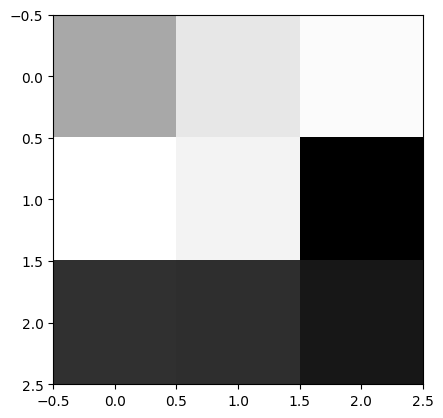

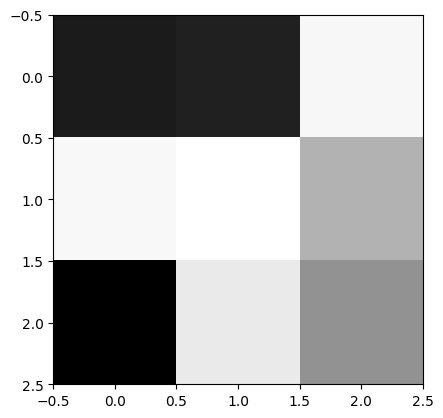

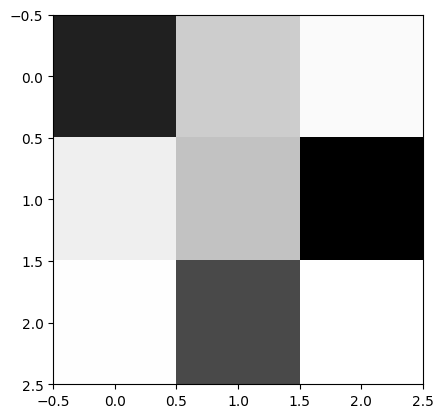

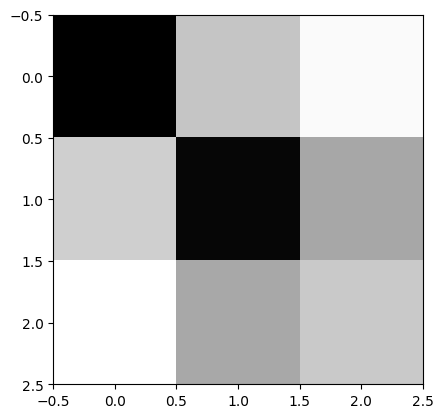

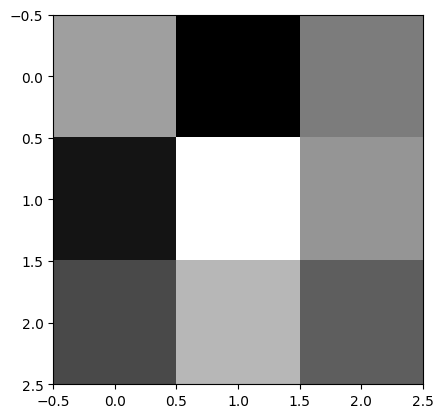

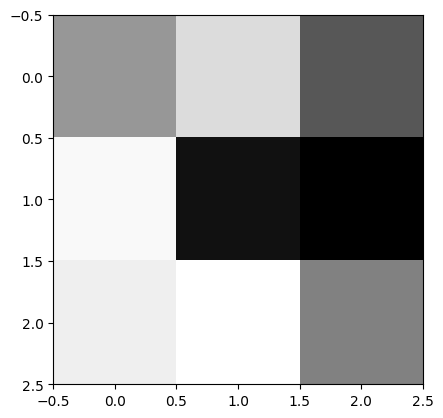

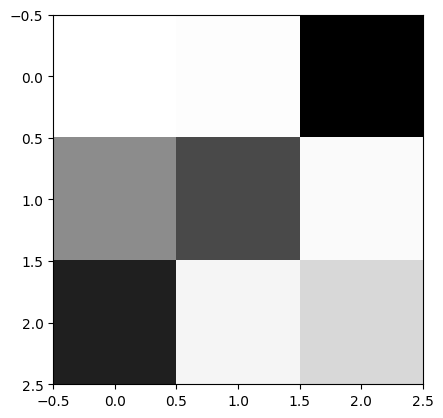

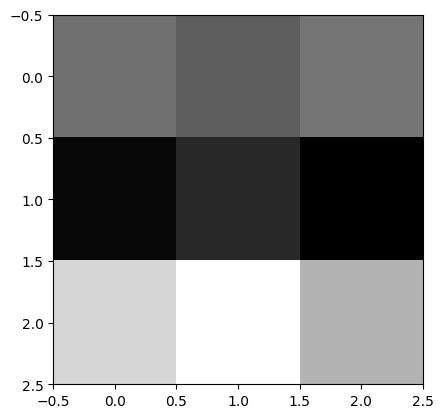

In [17]:

last_conv_layer = cnn.layers[4]  # Access the last convolutional layer
filters, bias = last_conv_layer.get_weights()  # Obtain filters and bias

for i in range(filters.shape[3]):  # Iterate through each filter
    filter_img = filters[:, :, :, i]  # Extract individual filter
    plt.imshow(filter_img[:, :, 0], cmap='gray')  # Plot filter as grayscale image
    plt.show()

**GradCAM**

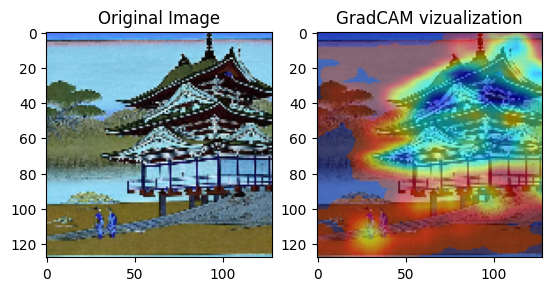

In [48]:
gradcam = Gradcam(cnn, model_modifier=None, clone=True)

input_image = x_test[40]

def loss(output):
  return (output[0][0], output[0][1])

cam = gradcam(loss,
              np.expand_dims(input_image, axis=0),
              penultimate_layer=-1) # model.layers[-1] is the last layer

cam = normalize(cam)
heatmap = np.uint8(255 * cam[0])

visualization = show_cam_on_image(input_image, heatmap, use_rgb=True)


# Display the visualization
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title('GradCAM vizualization')

plt.show()

